# SHAP Values Workshop

Welcome to the **SHAP Values Workshop**! During this session, we’ll explore how to interpret various machine learning model predictions using SHAP (SHapley Additive exPlanations).

## Workshop Overview

**Length**: 1.5 hours

1. **Introduction to SHAP Values (40 minutes)**
   - Overview of interpretability and its importance.
   - The theory behind Shapley values. (don't need to focus on this too much)
   - How SHAP extends Shapley values to machine learning.
   - Real world examples

2. **Break (10 minutes)**
   - We can use this time to ensure everyone's environment is setup correctly and pretrained models are loading, or just to stretch your legs.

3. **Hands-On SHAP Applications (40 minutes)**
   - Walkthrough with a simple multiple linear regression.
   - Walkthrough with a classifier.
   -  Walkthrough with a neural network (LSTM).

**We’ll use pretrained models (trained on the CAMELS dataset). You’ll load each model, run the SHAP package to generate explanations, and discuss how to interpret them.**


## 1. Applying SHAP to a Multiple Linear Regression

### 1.1 Dataset Overview
- Let's do some preliminary exploratory data analysis on the CAMELS dataset



In [3]:
# Set project directories
import os
# Back out one directory to project folder
PROJECT_DIR = os.path.dirname(os.path.abspath(''))
os.chdir(PROJECT_DIR)

# Set directories
DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
FIGURE_DIR = os.path.join(PROJECT_DIR, 'outputs','figures')
OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
CONFIG_DIR = os.path.join(PROJECT_DIR, "config")

In [ ]:
# Read in your data
import pandas as pd
df = pd.read_csv(os.path.join(DATA_DIR, 'CAMELS.csv'), index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

In [ ]:
df.drop(columns=['STAID'], inplace=True)
print(df.isna().sum())

In [ ]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(15, 15), grid=False)
plt.show()

### 1.2 Preprocess data 
- Split dataframe in X (inputs) and y (target) and scale input data from 0 - 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X = df.drop('Q', axis=1)
y = df['Q']

feat_scaler = MinMaxScaler()
X_sc = pd.DataFrame(
    feat_scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

y_scaler = MinMaxScaler()
y_sc = pd.Series(y_scaler.fit_transform(y.values.reshape(-1,1)).squeeze(),
    index=y.index, name='Q')

### 1.3 Loading the Pretrained Multiple Linear Regression
Use `np.load` to load pretrained multiple linear regression model


In [ ]:
# Load in pre-trained multiple linear regression model
import numpy as np
from sklearn.linear_model import LinearRegression

# Load in model from .npz file
w = np.load(os.path.join(MODEL_DIR, "linear_regression_weights.npz"), allow_pickle=True)

# Extract coefficients, intercepts, and feature names
linreg = LinearRegression()
linreg.coef_           = w["coef"]
linreg.intercept_      = w["intercept"][()]   
linreg.n_features_in_  = int(w["n_features_in"])

# Restore column labels
if w["feature_names_in"] is not None:
    linreg.feature_names_in_ = w["feature_names_in"]

### 1.3 Running SHAP Explanations
We'll use SHAP's `Explainer` for the **Multiple Linear Regression model**. Then we generate `shap_values` for the dataset.


In [ ]:
import shap
# Generate for 10% slice of time series starting at a random point
X_arr = np.array(X_sc)
y_arr = np.array(y_sc)
start = np.random.randint(0, X_sc.shape[0])
end = int(start + 0.1*len(X_sc))

# Store in arrays for future reference
X_shap = X_arr[start: end]
y_shap = y_arr[start: end]
feature_names = list(X.columns)

# Generate shap Explainer object and shap values
linear_explainer = shap.Explainer(linreg, X_shap)
shap_values = linear_explainer(X_shap)

### 1.4 Visualizing SHAP values
- The SHAP package has built in visualizations to help interpret SHAP values. **We can examine SHAP values globally or for local predictions.**
- In this workshop, we'll explore 3 visualization techniques:

    1. **Bar plot** (feature importance)

    2. **Beeswarm plot** (feature attribution)

    3. **Dependence plot** (How a single feature affects predictions)

    3. **Force Plot** (balance of forces for a given prediction) (just do locally)


#### 1.4.1 Bar Plots
- Bar plots are used to visualize overall feature importance based on their SHAP values, but doesn't contain any information on the directionality of the feature-prediction relationship.

In [ ]:
# A global feature importance bar plot
shap.bar_plot(shap_values, X_shap, feature_names=feature_names)

In [ ]:
# A local feature importance plot
shap.bar_plot(shap_values, X_shap[0: ], feature_names=feature_names)

#### 1.4.2 Beeswarm plots
- Beeswarm plots show not only feature importance, but feature directionality as well

In [ ]:
# A global feature importance plot
shap.summary_plot(shap_values, X_shap, feature_names=feature_names)

In [ ]:
# A local feature importance plot
shap.summary_plot(shap_values, X_shap[0, :], feature_names=feature_names)

#### Local Explanations
Use a force plot to explain a single observation in detail.


In [ ]:
# Example for local explanation:
# shap.plots.force(shap_values[0])  # explain the first sample

## 2. Neural Network (LSTM) with SHAP

- Now we'll demonstrate generating and interpreting SHAP values with a Neural Network (LSTM) model

## 3. Applying SHAP to a Classifier
Objective:  Use SHAP values to explore features associated with unique baseflow regimes.

### 3.1 Dataset overview
- Approximately 800 reference-quality gages across CONUS from GAGES-II dataset.
- Watershed characteristics (climatic, geographic, hydrologic, geologic, land use, etc....) for each gage.
- Gages clustered into seven clusters based on long-term baseflow behavior.

### 3.2 Methodology
- Random Forest Classification model used to predict a gage's cluster based on watershed characteristics.
- SHAP explanation object generated on the classification model.

See:    *van der Heijden, R., Dadkhah, A., Hamshaw, S., Ghazanfari, E., Dewoolkar, M., Jones, N., Williams, G., Prabhakar, C., Rizzo, D.M.
        "Identifying and interpreting physical processes and NWM prediction bias associated with baseflow regimes across the CONUS".
        Water Resources Research (under review)*


Questions / comments: rvanderh@uvm.edu

In [1]:
#%% Import Libraries
import numpy as np
import pandas as pd
import shap
import os
import matplotlib.pyplot as plt
from matplotlib import colors
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# set up plot preferences
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 12

/opt/anaconda3/envs/SHAP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv(os.path.join(MODEL_DIR, 'RF_classifier_DevCon.csv'))
data.drop(columns=['STAID'], inplace=True)

In [6]:
# Model Setup
y = data['Cluster_H_7']
X = data.drop(columns=['Cluster_H_7'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# The model parameters have already been tuned
tuned_params = {
    'n_estimators': 800,
    'max_features': 'sqrt',
    'max_depth': 70,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True
    }

In [7]:
# Fit model to training data
rf = RandomForestClassifier(n_estimators = tuned_params['n_estimators'],
                            max_depth = tuned_params['max_depth'],
                            max_features = tuned_params['max_features'],
                            min_samples_leaf = tuned_params['min_samples_leaf'],
                            min_samples_split = tuned_params['min_samples_split'],
                            bootstrap = tuned_params['bootstrap'],
                            random_state = 742
                            )

rf.fit(X_train, y_train)

# Add cluster number to X_test
X_test = pd.merge(left=X_test, right=data['Cluster_H_7'], left_index=True, right_index=True)

In [8]:
# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

### 3.3 About the Explanation Object
- The explanation object was created only using the test subset of the data
- For this exercise, the explanation object only included the 10 most important features.
- The size of the explanation object depends on these factors:


[# data points : # features : # output classes]

[156 data points in the test set : 10 features : 7 output classes]

In [9]:
# Generate explanation object and compute SHAP values
explainer = shap.Explainer(rf, X_test)
sv = explainer(X_test, check_additivity=False)

# check the shape of the explanation object
sv.shape

 99%|===================| 1078/1092 [01:11<00:00]        

(156, 11, 7)

### 3.4 About the Beeswarm Plot

The beeswarm plot is a collection of features associated with the output class. For a classification model, each output class has it's own beeswarm plot.

The features are arranged on the y-axis and ordered by feature importance, with the most importand features appearing at the top.

For each feature, all data points are shown (i.e., in this case 156 data points), arranged along the x-axis by their **SHAP value**, with vertical spread indicating density akin to a violin plot.

The data points are color-coded based on their **feature value**. Note that the color ramp is scaled to the range of values of each feature individually, thus is shows a relative magnitude ("high" or "low" feature values).

To interrogate the model further, we can look at the actual distribution of feature values (more on this later...).

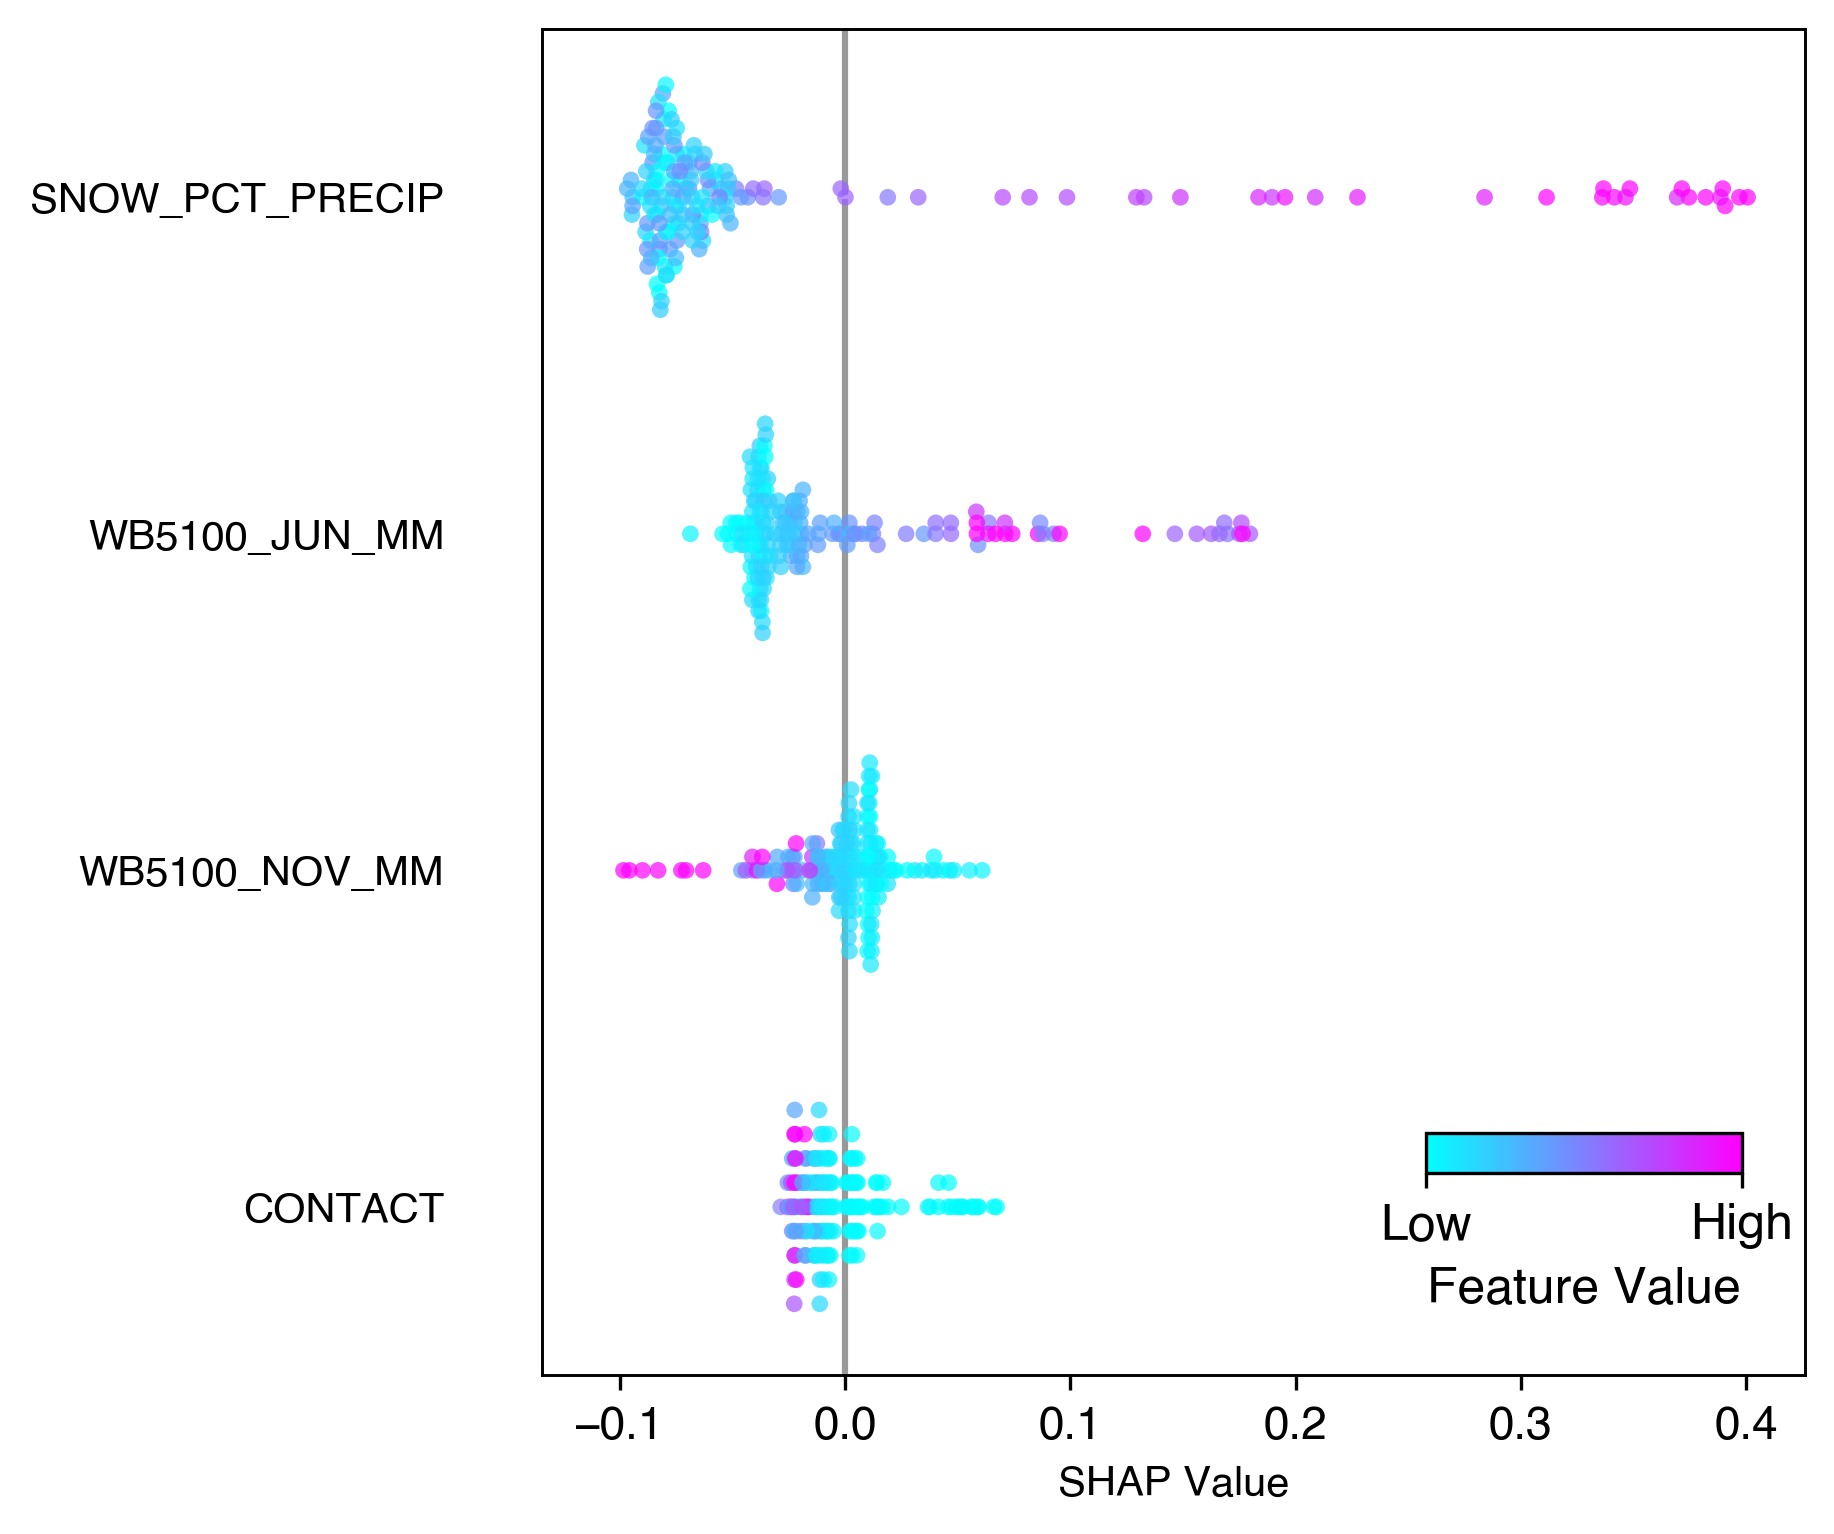

In [10]:
# Let's look at Cluster 2, which is predominantly in the intermountain-west physiographic region
clust = 2

# Construct a beeswarm plot by modifying the built-in shap.plots.beeswarm
#### Figure
fig, ax = plt.subplots(dpi=300, layout='constrained')

#### Plots
shap.plots.beeswarm(sv[:,:,(clust-1)],              # slice the SHAP values [all data points : all features : selected output class]
                    axis_color='k',
                    color=plt.get_cmap('cool'),
                    alpha=0.7,
                    order=shap.Explanation.abs.mean(0),     # SHAP provides a few methods for ordering features (see documentation)
                    color_bar=False,
                    show=False,
                    plot_size=(6, 5))

#### Axes
# For clarity, just showing the top 4 features
ax.set_ylim(5.5, 9.5)
ax.set_xlabel('SHAP Value', fontsize=10)
ax.tick_params(axis='y', which='major', labelsize=10)

# Set visibility of plot frame lines
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(0.7)

ax.grid(visible=True, which='Major', axis='y',
        color='w', linestyle='-', linewidth=1)

# Colorbar
cax = ax.inset_axes([0.7, 0.15, 0.25, 0.03])
img = ax.scatter(x=[0,0], y=[0,0], c=[0,1], cmap='cool')
cbar=fig.colorbar(img, ticks=[0, 1],
                    fraction = 0.05,
                    pad = 0.05,
                    cax=cax,
                    label='Feature Value',
                    orientation='horizontal')
cbar.ax.set_xticklabels(['Low', 'High'])

plt.show()

### 3.4 KDE Plots

Text(0.02, 0.5, 'Density')

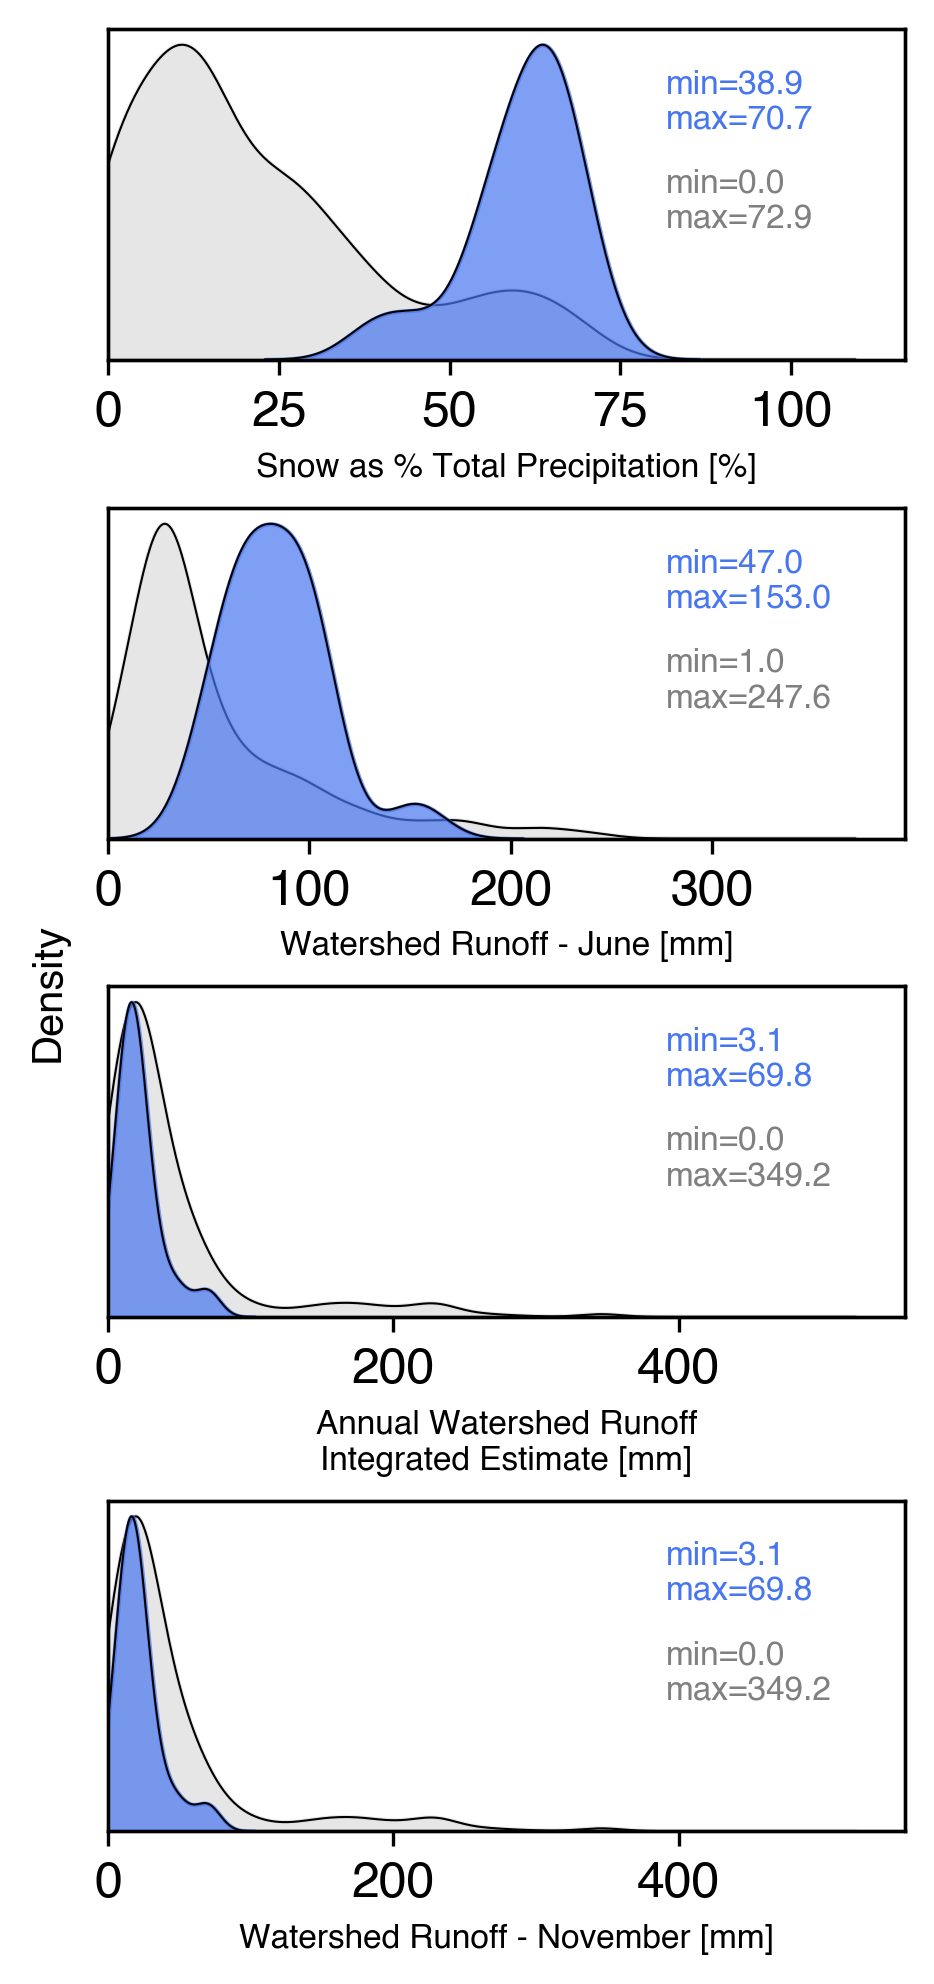

In [11]:
# These characteristics are for Cluster 2, and you will need to change them manually depending on the cluster you want to plot
c = '#4776ee'
var = ['SNOW_PCT_PRECIP', 'WB5100_JUN_MM', 'WB5100_NOV_MM', 'WB5100_NOV_MM']
feat = ['Snow as % Total Precipitation [%]', 'Watershed Runoff - June [mm]', 'Annual Watershed Runoff\nIntegrated Estimate [mm]', 'Watershed Runoff - November [mm]']

anno_coords = [
(0.7, 0.7),
(0.7, 0.7),
(0.7, 0.7),
(0.7, 0.7)
]
dist_coords = [
(0.7, 0.4),
(0.7, 0.4),
(0.7, 0.4),
(0.7, 0.4)
]

# Figure showing distributions
fig, ax = plt.subplots(figsize=(3, 6.5), nrows=4, ncols=1, sharex=False, sharey=False, dpi=300, layout='constrained')

for i in range(0, len(var)):
    kde = data[var[i]]
    plot = kde.plot.kde(ax=ax[i], style=['k'], linewidth=0.5)
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y
    
    ax[i].fill_between(x,y,color='gainsboro', alpha=0.7)

    # plot cluster points
    x_clust = X_test[var[i]][X_test['Cluster_H_7'] == clust]
    ax2 = ax[i].twinx()
    var_dist = x_clust.plot.kde(ax=ax2, style=['k'], linewidth=0.5)
    x_var = var_dist.get_children()[0]._x
    y_var = var_dist.get_children()[0]._y
    ax2.fill_between(x_var,y_var,color=c, alpha=0.7, label='_nolegend_')

    ax2.set_ylabel('')
    ax2.set_yticklabels('')
    ax2.set_yticks([])
    ax2.set_ylim(0)

    # Annotation for gray distribution
    ax[i].annotate('min={}\nmax={}'.format(min(kde), max(kde)), dist_coords[i], xycoords='axes fraction', fontsize=8, color='gray')
    # Annotation for color distribution
    ax[i].annotate('min={}\nmax={}'.format(min(x_clust), max(x_clust)), anno_coords[i], xycoords='axes fraction', fontsize=8, color=c)

for i in range(0, len(var)):
    ax[i].set_ylabel('')
    ax[i].set_yticklabels('')
    ax[i].set_yticks([])
    ax[i].set_ylim(0)
    ax[i].set_xlim(0)
    ax[i].set_xlabel(feat[i], fontsize=8)

fig.supylabel('Density', fontsize=10)

## 6. Wrap-Up and Next Steps
- **Summary of Key Takeaways**:

## 7. Q&A and Resources
- **Q&A**: Ask questions about usage, best practices, or advanced features.
- **Resources**:
  - [SHAP GitHub repo](https://github.com/slundberg/shap)
  - [Official SHAP documentation and example notebooks](https://shap.readthedocs.io/en/latest/)
  - [Original SHAP paper (Lundberg & Lee, 2017)](https://arxiv.org/pdf/1705.07874)

Thank you for attending the **SHAP Values Workshop**!